<a href="https://colab.research.google.com/github/mag381/kame/blob/main/Open_AI_Gym_Box2D_BipedalWalker%E3%82%92Colaboratory%E3%81%A7%E5%8B%95%E3%81%8B%E3%81%97%E3%81%A6%E3%81%BF%E3%82%8B(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Open AI Gym Box2D BipedalWalkerをColaboratoryで動かしてみる(6)

ただし、実行内容は　'MountainCarContinuous-v0'

https://akifukka.hatenablog.com/entry/BipedalWalker6

In [1]:
!pip3 install box2d-py
!pip3 install 'gym[Box2D]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!apt-get update
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg
!pip3 -q install pyglet
!pip3 -q install pyopengl
!pip3 -q install pyvirtualdisplay
!apt-get install x11-utils
!pip3 install pybullet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [87.8 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [886 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/ma

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from pyvirtualdisplay import Display
from scipy.interpolate import interp1d

In [4]:
display = Display(visible=0, size=(1024, 768))
display.start()
import os
#pyvirtualdisplayの仕様変更で次の文はエラーになるのでコメントアウトします（2021/6/5修正）
#os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

#Bipedalwalkerのv2は無くなったのでv3に変更（2021/6/5）
#env = gym.make('Bipedalwalker-v3')　# なぜか二本足が動かないので、山登りの車にした
env = gym.make('MountainCarContinuous-v0')


In [5]:

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#リプレイメモリー
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
   
    def reset(self):
        self.memory = []
        self.position = 0   

#Actor(Polycy) Network
class Policy_net(nn.Module):
    def __init__(self, NumObs, NumAct,NumHidden):
        super(Policy_net, self).__init__()
        self.ln1 = nn.Linear(NumObs, NumHidden)
        self.ln2 = nn.Linear(NumHidden, NumHidden)
        self.ln3 = nn.Linear(NumHidden, NumHidden)
        self.ln4 = nn.Linear(NumHidden, NumAct)
        self.ln4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.relu(self.ln3(x))
        y = torch.tanh(self.ln4(x))
        return y

#Critic(Q) Network Q値の計算
class Q_net(nn.Module):
    def __init__(self, NumObs, NumAct,NumHidden1,NumHidden2):
        super(Q_net, self).__init__()
        self.ln1 = nn.Linear(NumObs, NumHidden1)
        self.ln2 = nn.Linear(NumHidden1+NumAct, NumHidden2)
        self.ln3 = nn.Linear(NumHidden2, NumHidden2)
        self.ln4 = nn.Linear(NumHidden2, 1)
        self.ln4.weight.data.uniform_(-3e-3, 3e-3)
        self.bn1 = nn.BatchNorm1d(num_features=NumHidden2)

    def forward(self, state, action):
        x = F.leaky_relu(self.ln1(state))
        x = torch.cat((x, action), dim=1)
#        x = F.leaky_relu(self.bn1(self.ln2(x)))
        x = F.leaky_relu(self.ln2(x))
        x = F.leaky_relu(self.ln3(x))
        y = self.ln4(x)
        return y

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    #batchを一括して処理するためtensorのリストを2次元テンソルに変換
    state_batch = torch.stack(batch.state,dim=0)
    action_batch = torch.stack(batch.action,dim=0)
    reward_batch = torch.stack(batch.reward,dim=0)
    next_state_batch = torch.stack(batch.next_state,dim=0)
    done_batch = torch.stack(batch.done,dim=0)

    #Qネットのloss関数計算
    next_actions = policy_target_net(next_state_batch)
    next_Q_values =q_target_net(next_state_batch ,next_actions)
    expected_Q_values = (next_Q_values * GAMMA)*(1.0-done_batch) + reward_batch

    Q_values =  q_net(state_batch ,action_batch)

    #Qネットのloss関数
    q_loss = F.mse_loss(Q_values,expected_Q_values)

    #Qネットの学習
    q_optimizer.zero_grad()
    #誤差逆伝搬
    q_loss.backward()
    #重み更新
    q_optimizer.step()

    #policyネットのloss関数
    actions = policy_net(state_batch)
    p_loss = -q_net(state_batch,actions).mean()

    #policyネットの学習
    p_optimizer.zero_grad()
    #誤差逆伝搬
    p_loss.backward()
    #重み更新
    p_optimizer.step()

    tau = 0.001
    #targetネットのソフトアップデート
    #学習の収束を安定させるためゆっくり学習するtarget netを作りloss関数の計算に使う。
    #学習後のネット重み×tau分を反映させ、ゆっくり追従させる。
    for target_param, local_param in zip(policy_target_net.parameters(), policy_net.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    for target_param, local_param in zip(q_target_net.parameters(), q_net.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

#action,observationの要素数取得
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
print('num actions,observations',n_actions,n_observations )

#ネットワーク
#policyネットとそのtargetネット
policy_net = Policy_net(n_observations, n_actions,128).to(device)
policy_target_net = Policy_net(n_observations, n_actions,128).to(device)
#Qネットとそのtargetネット
q_net = Q_net(n_observations, n_actions, 64, 128).to(device)
q_target_net = Q_net(n_observations, n_actions, 64, 128).to(device)
#学習用optimizer生成
p_optimizer = optim.Adam(policy_net.parameters(),lr=1e-3)
q_optimizer = optim.Adam(q_net.parameters(),lr=3e-3, weight_decay=0.0001)
#学習用リプレイメモリ生成
memory = ReplayMemory(1000000)
memory.reset()
#ノイズの大きさ計算用、最初は大きくして学習が進んだら小さくするためのカウンタ
steps_done = 0

num actions,observations 1 2


In [6]:
#BATCH_SIZE = 128
BATCH_SIZE = 128
#Qネット学習時の報酬の割引率
GAMMA = 0.98
#steps_doneに対するノイズの減少係数
SIGMA_START = 1.0 #最初
SIGMA_END = 0.3 #最後
SIGMA_DECAY = 800 #この回数で約30%まで減衰

#50 フレーム/sec グラフ描画用
FPS = 50
#学習数。num_epsode=200を変更する。
num_episodes = 1000

for i_episode in range(num_episodes):
    #whileループ内初期化
    observation = env.reset()
    done = False
    reward_total = 0.0
    t = 0
    #グラフ用データ保存領域初期化
    frames = []
    observations = []
    actions = []
    ts = []
    for i in range(n_observations):
      observations.append([])
    for i in range(n_actions):
      actions.append([])

    noise =np.array([random.uniform(-0.5,0.5) for i in range(n_actions)],dtype = np.float)
    theta = 0.08
    sigma = SIGMA_END + (SIGMA_START - SIGMA_END) * math.exp(-1. * steps_done / SIGMA_DECAY)
    steps_done += 1

    while not done and t < 700:
        #指令値生成------------------------------------
        sample = random.random()

        with torch.no_grad():
          action = policy_net(torch.from_numpy(observation).float().to(device))
          action = action.cpu().data.numpy()

        #最後は純粋にネットワークのデータを取得するためノイズ無し-------------------
        if (i_episode != num_episodes -1 ):
          #OUNoise
          noise = noise - theta * noise + sigma * np.array([random.uniform(-1.0,1.0) for i in range(len(noise))])
          action += noise

        action = np.clip(action, -1, 1)

        #物理モデル1ステップ---------------------------
        next_observation, reward, done, info = env.step(action)
        reward_total = reward_total + reward

        #学習用にメモリに保存--------------------------
        tensor_observation = torch.tensor(observation,device=device,dtype=torch.float)
        tensor_action = torch.tensor(action,device=device,dtype=torch.float)
        tensor_next_observation = torch.tensor(next_observation,device=device,dtype=torch.float)
        tensor_reward = torch.tensor([reward],device=device,dtype=torch.float)
        tensor_done =  torch.tensor([done],device=device,dtype=torch.float)
        memory.push(tensor_observation, tensor_action, tensor_next_observation, tensor_reward,tensor_done)

        #observation(state)更新------------------------
        observation = next_observation

        #学習してpolicy_net,target_neを更新
        optimize_model()
        #データ保存------------------------------------
        if i_episode == num_episodes -1 :
          #動画
          frames.append(env.render(mode = 'rgb_array'))
          #グラフ
          for i in range(n_observations):
            observations[i].append(observation[i])
          for i in range(n_actions):
            actions[i].append(action[i])
          ts.append(t/FPS)

        #時間を進める----------------------------------
        t += 1
        # end while loop ------------------------------
    if (steps_done % 10 == 0) or (i_episode == num_episodes -1 ):
#      print('episode,reward=',i_episode,reward_total)
      print('episode,reward=',steps_done,reward_total)
  # end for loop --------------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


episode,reward= 10 91.40679042134745
episode,reward= 20 90.58521919893863
episode,reward= 30 88.57440284509218
episode,reward= 40 82.02965646078104
episode,reward= 50 84.47015589340624
episode,reward= 60 83.8229780970624
episode,reward= 70 81.43361261369607
episode,reward= 80 93.60449592116407
episode,reward= 90 89.28482255695445
episode,reward= 100 93.96451682966139
episode,reward= 110 93.96120683645104
episode,reward= 120 88.98010783921261
episode,reward= 130 87.14123073386627
episode,reward= 140 81.8184875377033
episode,reward= 150 80.57781969735154
episode,reward= 160 60.74032531207766
episode,reward= 170 74.72658908641712
episode,reward= 180 90.35354648431084
episode,reward= 190 90.53538284590263
episode,reward= 200 89.21123435938415
episode,reward= 210 93.12812443437763
episode,reward= 220 91.07721678776
episode,reward= 230 92.51110835104187
episode,reward= 240 93.17691127413484
episode,reward= 250 91.70475919518466
episode,reward= 260 94.31386130169072
episode,reward= 270 90.481

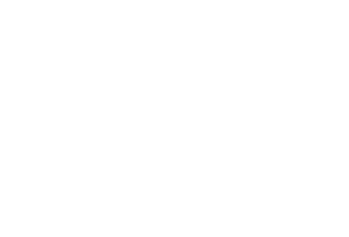

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

fig2 = plt.figure(figsize=(6, 6))
plt.axis('off')

images = []
for f in frames:
  image = plt.imshow(f)
  images.append([image])
ani = matplotlib.animation.ArtistAnimation(fig2, images, interval=30, repeat_delay=1)

HTML(ani.to_jshtml())